In [1]:
import numpy as np
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.image import extract_patches_2d
from PIL import Image
from functools import cmp_to_key
import cv2
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import argparse
import math
from math import sqrt
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
import seaborn as sns
import glob

## Global Variables ##

In [2]:
# Determines the length of floats the SIFT function will tolerate
float_tolerance = 1e-7

# Determines whether to run SIFT in verbose mode
# (Prints out messages for debugging)
VERBOSE_MODE = False

# SIFT Implementation #

Please note: This implementation is largely based on the one originally created by Russ Islam, which can be found here:
https://github.com/rmislam/PythonSIFT

## Image Pyramid Functions ##

In [3]:
# Generate the base image from the given input image
# by upsampling by 2 in both directions and then applying
# a Gaussian blur.
def generateBaseImage(image, sigma, assumed_blur):
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    
    # The image blur is now sigma instead of assumed_blur
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  

# Compute number of octaves in the image pyramid based
# on the original OpenCV implementation.
# (Function of base image shape)
def computeOctaves(img_shape):
    return int(round(log(min(img_shape)) / log(2)-1))

# Generate a list of Gaussian Kernels at which to blur the image
# Default values of sigma, intervals, and octaves are based on section 3
# of David G. Lowe's paper.
def generateGaussianKernels(sigma, intervals):
    # Set number of intervals
    images_per_octave = intervals + 3
    k = 2 ** (1.0 / intervals) # Normalise
    
    # Scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels = zeros(images_per_octave)
    gaussian_kernels[0] = sigma

    # For each image, work out the appropriate sigma value
    for image_index in range(1, images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

# Generate the scale-space pyramid of Gaussian Images
# See: Lecture 7 - Page 14
def generateGaussianImages(img, octaves, kernels):
    
    gaussian_images = []
    
    for octave_index in range(octaves):
        gaussian_images_in_octave = []
        # First image in pyramid already has the correct blur
        gaussian_images_in_octave.append(img)
        
        # Blur each image
        for kernel in kernels[1:]:
            #print(kernel) DEBUG
            #img = gaussian_blur(img, 1, kernel) # ORIGINALLY 0
            img = GaussianBlur(img, (0, 0), sigmaX=kernel, sigmaY=kernel)
            gaussian_images_in_octave.append(img)
        
        # Append images to master array
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        
        # Resize image
        img = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    
    return array(gaussian_images, dtype=object)

# Generate a Difference of Gaussian (DoG) image pyramid
def generateDoGImages(gaussian_images):
    
    dog_images = []
    
    # Similar process to latter function
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            # Ordinary subtraction will not work because the images are unsigned integers
            dog_images_in_octave.append(subtract(second_image, first_image))
        
        dog_images.append(dog_images_in_octave)
        
    return array(dog_images, dtype=object)

## Scale Space Extrema Functions ##

In [4]:
# Find the pixel positions of all Scale-Space Extrema in the image pyramid
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):

    # From OpenCV implementation
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    # Checks for extrenum values
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

# Returns true if the centre element of the 3x3x3 input array is strictly greater
# than or less than all of its neighbours, and false otherwise
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
  centre_pixel_value = second_subimage[1,1]

  # Checks if pixel value is above the given threshold
  if abs(centre_pixel_value) > threshold:
    if centre_pixel_value > 0:
      # Check pixel against its neighbours
      return all(centre_pixel_value >= first_subimage) and \
                   all(centre_pixel_value >= third_subimage) and \
                   all(centre_pixel_value >= second_subimage[0, :]) and \
                   all(centre_pixel_value >= second_subimage[2, :]) and \
                   centre_pixel_value >= second_subimage[1,0] and \
                   centre_pixel_value >= second_subimage[1,2]
    elif centre_pixel_value < 0:
        return all(centre_pixel_value <= first_subimage) and \
                all(centre_pixel_value <= third_subimage) and \
                all(centre_pixel_value <= second_subimage[0, :]) and \
                all(centre_pixel_value <= second_subimage[2, :]) and \
                centre_pixel_value <= second_subimage[1,0] and \
                centre_pixel_value <= second_subimage[1,2]
  return False

# Iteratively refine pixel positions of Scale Space extrema
# via quadratic fit around each extremum's neighbors
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, intervals, dog_images_in_octave, 
                                    sigma, contrast_threshold, image_border_width, 
                                    eigenvalue_ratio=10, attempts_until_convergence=5):
  extremum_is_outside_image = False
  image_shape = dog_images_in_octave[0].shape

  for attempt_index in range(attempts_until_convergence):
    # We need to convert from uint8 to float32 to compute derivatives
    # after which we need to rescale pixel values to [0, 1] to apply Lowe's thresholds
    first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
    pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                        second_image[i-1:i+2, j-1:j+2],
                        third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
    # Compute the gradient and hessian values
    gradient = computeGradientAtCentrePixel(pixel_cube)
    hessian = computeHessianAtCentrePixel(pixel_cube)

    # Compute the least-squares solution of the hessian and the gradient matrices
    extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
    if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
        break
    j += int(round(extremum_update[0]))
    i += int(round(extremum_update[1]))
    image_index += int(round(extremum_update[2]))

    # Make sure the new pixel_cube will lie entirely within the image
    if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > intervals:
        extremum_is_outside_image = True
        break

  # Logging functions
  if extremum_is_outside_image:
      #logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
      return None
  if attempt_index >= attempts_until_convergence - 1:
      #logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
      return None

  functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
  if abs(functionValueAtUpdatedExtremum) * intervals >= contrast_threshold:
      xy_hessian = hessian[:2, :2]
      xy_hessian_trace = trace(xy_hessian)
      xy_hessian_det = det(xy_hessian)
      if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
          # Contrast check passed -- construct and return OpenCV KeyPoint object
          # MAKE OWN KEYPOINT^^^
          keypoint = KeyPoint()
          keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
          keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
          # Octave_index + 1 because the input image was doubled
          keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(intervals))) * (2 ** (octave_index + 1)) 
          keypoint.response = abs(functionValueAtUpdatedExtremum)
          return keypoint, image_index
  return None

# Approximate the gradient at the centre pixel (of 3x3x3 array)
# by using the "Central Difference" formula (Order: O(h^2))
# See: https://learn.lboro.ac.uk/archive/olmp/olmp_resources/pages/workbooks_1_50_jan2008/Workbook31/31_3_num_diff.pdf
def computeGradientAtCentrePixel(pixel_array):
  # Central Difference formula considering h (step size) of order O(h^2) for f'(x) 
  # is (f(x + h) - f(x - h)) / (2 * h)
  # Since h=1 in this case, we get: f'(x) = (f(x + 1) - f(x - 1)) / 2
  # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
  dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
  dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
  ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])

  return array([dx, dy, ds])

# Same principles as the function above
def computeHessianAtCentrePixel(pixel_array):
  
  # Central Difference formula considering h (step size) of order O(h^2) for 
  # (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
  # Since h=1 in this case, we get: 
  # (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
  
  centre_pixel_value = pixel_array[1,1,1]

  dxx = pixel_array[1,1,2] - 2 * centre_pixel_value + pixel_array[1,1,0]
  dyy = pixel_array[1,2,1] - 2 * centre_pixel_value + pixel_array[1,0,1]
  dss = pixel_array[2,1,1] - 2 * centre_pixel_value + pixel_array[0,1,1]

  dxy = 0.25 * (pixel_array[1,2,2] - pixel_array[1,2,0] - pixel_array[1,0,2] + pixel_array[1,0,0])
  dxs = 0.25 * (pixel_array[2,1,2] - pixel_array[2,1,0] - pixel_array[0,1,2] + pixel_array[0,1,0])
  dys = 0.25 * (pixel_array[2,2,1] - pixel_array[2,0,1] - pixel_array[0,2,1] + pixel_array[0,0,1])
  return array([[dxx, dxy, dxs], 
              [dxy, dyy, dys],
              [dxs, dys, dss]])

## Keypoint Orientation Function ##

In [5]:
# Computes the orientations of each keypoint
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, 
                                     num_bins=36, peak_ratio=0.8, scale_factor=1.5):
  keypoints_with_orientations = []
  image_shape = gaussian_image.shape

  # Comparison with keypoint.size computation in "localizeExtremumViaQuadraticFit()"
  scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))

  # Prepare histogram values
  radius = int(round(radius_factor * scale))
  weight_factor = -0.5 / (scale ** 2)
  raw_histogram = zeros(num_bins)
  smooth_histogram = zeros(num_bins)

  # Go through the Y-range
  for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            # Go through the X-range
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    
                    # Constant in front of exponential can be dropped since peaks will be found later
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude
  
  # Iterate through number of histogram bins
  for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
  
  orientation_max = max(smooth_histogram)
  orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
  
  # For each peak value in orientation_peaks
  for peak_index in orientation_peaks:
      peak_value = smooth_histogram[peak_index]
      if peak_value >= peak_ratio * orientation_max:
          # Quadratic peak interpolation
          # The interpolation update is given by equation (6.30) in:
          # https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html

          left_value = smooth_histogram[(peak_index - 1) % num_bins]
          right_value = smooth_histogram[(peak_index + 1) % num_bins]
          interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
          orientation = 360. - interpolated_peak_index * 360. / num_bins
          if abs(orientation - 360.) < float_tolerance:
              orientation = 0
          new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
          keypoints_with_orientations.append(new_keypoint)
  return keypoints_with_orientations


## Duplicate Keypoint Removal Functions ##

In [6]:
# Returns true if the first keypoint is "less" than the second
# Used in the next function to remove duplicate keypoints
def compareKeypoints(keypoint1, keypoint2):

  # All attributes of the keypoints are compared
  if keypoint1.pt[0] != keypoint2.pt[0]:
    return keypoint1.pt[0] - keypoint2.pt[0]
  if keypoint1.pt[1] != keypoint2.pt[1]:
    return keypoint1.pt[1] - keypoint2.pt[1]
  if keypoint1.size != keypoint2.size:
    return keypoint2.size - keypoint1.size
  if keypoint1.angle != keypoint2.angle:
    return keypoint1.angle - keypoint2.angle
  if keypoint1.response != keypoint2.response:
    return keypoint2.response - keypoint1.response
  if keypoint1.octave != keypoint2.octave:
    return keypoint2.octave - keypoint1.octave
  return keypoint2.class_id - keypoint1.class_id

# Sorts the keypoints and then removes any duplicates
def removeDuplicateKeypoints(keypoints):
    # Checks if there is only 1 or no keypoints
    if len(keypoints) < 2:
        return keypoints
    
    # The sort method is called with a key pointing to the previous function.
    # This allows the program to run the function on each element while it is sorting.
    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]
    
    # Remove the duplicate keypoints
    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
            
    return unique_keypoints

## Keypoint Scale Conversion Function ##

In [7]:
# Converts the keypoint point, size, and octave to the size to the input image
def convertKeypointsToInputImageSize(keypoints):

  converted_keypoints = []

  for keypoint in keypoints:
    keypoint.pt = tuple(0.5 * array(keypoint.pt))
    keypoint.size *= 0.5

    # The "~" is the bitwise operator. It returns (-x) - 1 (e.g. ~4 = -5)
    # The "|" operator is the union operator for sets, but here it is used
    # as a standard binary operator <- CHECK!!!
    keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)

    # Add the newly converted keypoint to array
    converted_keypoints.append(keypoint)
  
  return converted_keypoints

## Descriptor Generation ##

In [8]:
# Compute octave, layer, and scale from a keypoint
def unpackOctave(keypoint):
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

# Generates the descriptors for each keypoint
def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8,
                        scale_multiplier=3, descriptor_max_value=0.2):
    
    descriptors = []

    # Iterate through each keypoint
    for keypoint in keypoints:
        
        # Here, we will create a new gradient histogram for each
        # keypoint. Then, we also calculate the gradient magnitude
        # and orientation of each pixel.
        
        # Unpack the octave and begin histogram creation
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        
        # Work out the orientation
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        
        # We don't actually "draw" the histograms, we simply keep track of the
        # bin values and bin indexes.
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        
        # The first two dimensions are increased by 2 to account for border effects
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        
        # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))
        
        # Ensure half_width lies within image
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     

        # Calculating each pixel's (hence iteration) gradient magnitude and orientation
        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

## Main SIFT Function ##

In [9]:
# Computes the SIFT descriptors and keypoints for a given image
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    
    if (VERBOSE_MODE == True):
        img_temp = image
        image = image.astype('float32')
        print("GENERATING BASE IMAGE...")
        base_image = generateBaseImage(image, sigma, assumed_blur)
        print("OK!")
        print("COMPUTING OCTAVES...")
        num_octaves = computeOctaves(base_image.shape)
        print("OK!")
        print("GENERATING KERNELS...")
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        print("OK!")
        print("GENERATING GAUSSIAN IMAGES...")
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        print("OK!")
        print("GENERATING DIFFERENCE OF GAUSSIAN IMAGES...")
        dog_images = generateDoGImages(gaussian_images)
        print("OK!")
        print("ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)")
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        print("OK!")
        print("REMOVING DUPLICATE KEYPOINTS...")
        keypoints = removeDuplicateKeypoints(keypoints)
        print("OK!")
        print("CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...")
        keypoints = convertKeypointsToInputImageSize(keypoints)
        print("OK!")
        print(keypoints)
        print("GENERATING DESCRIPTORS...")
        descriptors = generateDescriptors(keypoints, gaussian_images)
        print("OK!")
        print("DONE! RETURNING KEYPOINTS AND DESCRIPTORS... (PLEASE WAIT)")
        
        return keypoints, descriptors
    else:
        img_temp = image
        image = image.astype('float32')
        base_image = generateBaseImage(image, sigma, assumed_blur)
        num_octaves = computeOctaves(base_image.shape)
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        dog_images = generateDoGImages(gaussian_images)
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        keypoints = removeDuplicateKeypoints(keypoints)
        keypoints = convertKeypointsToInputImageSize(keypoints)
        descriptors = generateDescriptors(keypoints, gaussian_images)
        
        return keypoints, descriptors
    

# Loading The Dataset #

In [13]:
training_images = []
#test_images = []
labels = [] # 0 = cars, 1 = keyboards, 2 = dog, 3 = airplanes

# Reimport images
cars = [cv2.imread(file) for file in glob.glob("Training/Cars/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(cars):
  cars[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(cars):
  training_images.append(img)
  labels.append(0)

keyboards = [cv2.imread(file) for file in glob.glob("Training/Keyboard/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(keyboards):
  keyboards[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(keyboards):
  training_images.append(img)
  labels.append(1)

dogs = [cv2.imread(file) for file in glob.glob("Training/Dog/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(dogs):
  dogs[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(dogs):
  training_images.append(img)
  labels.append(2)

airplanes = [cv2.imread(file) for file in glob.glob("Training/Airplanes/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(airplanes):
  airplanes[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(airplanes):
  training_images.append(img)
  labels.append(3)


# Load all images from test dataset
cars_test = [cv2.imread(file) for file in glob.glob("Test/Cars/*.jpg")]
dogs_test = [cv2.imread(file) for file in glob.glob("Test/Dog/*.jpg")]
keyboards_test = [cv2.imread(file) for file in glob.glob("Test/Keyboard/*.jpg")]
airplanes_test = [cv2.imread(file) for file in glob.glob("Test/Airplanes/*.jpg")]

# HAS TO BE IN SAME ORDER AS LABELS!!!!!!!!
test_images = cars_test + keyboards_test + dogs_test + airplanes_test

for c in cars_test:
  labels.append(0)
for k in keyboards_test:
  labels.append(1)
for d in dogs_test:
  labels.append(2)
for a in airplanes_test:
  labels.append(3)

# Convert images to greyscale
for i, img in enumerate(test_images):
  test_images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #test_images.append(img)

# DEBUG
if (VERBOSE_MODE):
  print(len(training_images), "training images loaded!")
  print(len(test_images), "test images loaded!")
  print("Labels:")
  print(labels)
  cv2_imshow(training_images[2])

80
120
10
10
10


# K-Means Clustering Implementation (Step 2) #

In [14]:
def getOptimumK(desc):
  sil = []
  base = 3
  kmax = 12

  for k in range(base, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(desc)
    labels = kmeans.labels_
    sil.append(silhouette_score(desc, labels, metric = 'euclidean'))

  print(sil)

  print(np.amax(sil))
  optimum_k = sil.index(np.amax(sil)) + base

  return optimum_k

In [15]:
# Get Optimum Ks

training_desc_array = []
test_desc_array = []

training_kp_array = []
test_kp_array = []

training_k_array = []
test_k_array = []


# Compute features and the optimum k values for each training image
for index, img in enumerate(training_images):
  print("Computing Training Image", index+1, "...")
  kp, desc = computeKeypointsAndDescriptors(img)

  #print(desc)
  training_kp_array.append(kp)
  training_desc_array.append(desc)
  training_k_array.append(getOptimumK(desc))

  print("OK!")

# Compute features and the optimum k values for each test image
for index, img in enumerate(test_images):
  print("Computing Test Image", index+1, "...")
  kp, desc = computeKeypointsAndDescriptors(img)

  test_kp_array.append(kp)
  test_desc_array.append(desc)
  test_k_array.append(getOptimumK(desc))

  print("OK!")

if (VERBOSE_MODE):
  print("Descriptors sets for training images:", len(training_desc_array))
  print("Descriptors sets for test images:", len(test_desc_array))


Computing Training Image 1 ...
[0.07910899, 0.06880497, 0.061759505, 0.06359182, 0.066215046, 0.06323844, 0.06537438, 0.06385289, 0.061259888, 0.059445307]
0.07910899
OK!
Computing Training Image 2 ...
[0.05908405, 0.05040772, 0.05647744, 0.0643598, 0.06365633, 0.05724704, 0.06766016, 0.06769269, 0.073250696, 0.06765701]
0.073250696
OK!
Computing Training Image 3 ...
[0.085833825, 0.08125064, 0.07614661, 0.069913, 0.067135364, 0.06550055, 0.061296366, 0.06190232, 0.06374252, 0.063069716]
0.085833825
OK!
Computing Training Image 4 ...
[0.06700481, 0.063395925, 0.056150954, 0.058621213, 0.06229889, 0.06449481, 0.0618994, 0.050139792, 0.057721928, 0.054403786]
0.06700481
OK!
Computing Training Image 5 ...
[0.06916624, 0.052548412, 0.054011974, 0.05422758, 0.05103494, 0.054322258, 0.054285724, 0.059548385, 0.057521213, 0.06131702]
0.06916624
OK!
Computing Training Image 6 ...
[0.10567425, 0.07704004, 0.0782413, 0.07931918, 0.07012847, 0.07990138, 0.060118876, 0.060578898, 0.066125266, 0.05

## Assign descriptors to nearest cluster for both the training and test images (Step 2/3.2) ##

In [39]:
# Stores the dictionary of clusters
final_dictionary = []

# Size of dictionary
MAX_LIMIT = 500
count = 0

# Perform K-means clustering for each image
for image in range(len(training_images)):
  if count < MAX_LIMIT:
    kmeans = KMeans(training_k_array[image]).fit(training_desc_array[image])

    kmeans.predict(training_desc_array[image])
    cluster = []
    

    for k in range(training_k_array[image]):
      data = []
      for i in range(len(kmeans.labels_)):
        if kmeans.labels_[i] == k:
          data.append(training_desc_array[image][i])
      cluster.append(data)

    count += len(cluster)

    final_dictionary.append(cluster)


# Eliminating clusters to ensure correct dictionary word count
while count > MAX_LIMIT:
  final_dictionary[len(final_dictionary)-1].pop(len(final_dictionary[len(final_dictionary)-1])-1)
  count -= 1


sum = 0
for i, x in enumerate(final_dictionary):
  print("Size of Image Cluster is", len(x))
  sum += len(final_dictionary[i])


print("Sum:", sum)


Size of Image Cluster is 3
Size of Image Cluster is 11
Size of Image Cluster is 3
Size of Image Cluster is 3
Size of Image Cluster is 3
Size of Image Cluster is 3
Size of Image Cluster is 3
Size of Image Cluster is 10
Size of Image Cluster is 3
Size of Image Cluster is 9
Size of Image Cluster is 8
Size of Image Cluster is 3
Size of Image Cluster is 3
Size of Image Cluster is 3
Size of Image Cluster is 7
Size of Image Cluster is 5
Size of Image Cluster is 5
Size of Image Cluster is 5
Size of Image Cluster is 3
Size of Image Cluster is 9
Size of Image Cluster is 6
Size of Image Cluster is 11
Size of Image Cluster is 11
Size of Image Cluster is 6
Size of Image Cluster is 3
Size of Image Cluster is 10
Size of Image Cluster is 12
Size of Image Cluster is 4
Size of Image Cluster is 7
Size of Image Cluster is 8
Size of Image Cluster is 10
Size of Image Cluster is 8
Size of Image Cluster is 3
Size of Image Cluster is 3
Size of Image Cluster is 12
Size of Image Cluster is 5
Size of Image Cluste

In [17]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [34]:

z = e

print(z)


# Reimport images
extra = [cv2.imread(file) for file in glob.glob("Training/Extra/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(extra):
  extra[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(extra):
  training_images.append(img)
  labels.append(0)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [37]:
print(labels)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
for index, img in enumerate(extra):
  print("Computing Extra Image", index+1, "...")
  kp, desc = computeKeypointsAndDescriptors(img)

  #print(desc)
  training_kp_array.append(kp)
  training_desc_array.append(desc)
  training_k_array.append(getOptimumK(desc))

  print("OK!")

## Step 3.1 - Finding Euclidean Distances ##

In [40]:
distances = []

for x in range(len(training_images)):
    distances.append([])

print(distances)

for image in range(len(training_images)):

  kmeans = KMeans(training_k_array[image]).fit(training_desc_array[image])
  kmeans.predict(training_desc_array[image])

  centroids = kmeans.cluster_centers_

  # Euclidean distance of image descriptors with centroids
  # subtract descriptors with centroids
  for desc in training_desc_array[image]:
    for c in centroids:
      distance = np.linalg.norm(desc - c)

      distances[image].append(distance)

#printing the euclidean distances
for d in range(len(training_images)):
  print("Distances for Image", d+1)
  for x in distances[d]:
    print(x)

Streaming output truncated to the last 5000 lines.
387.46274
465.82864
447.2215
351.54718
513.09235
574.2809
460.36465
396.12796
408.35107
462.9473
408.8983
420.96753
388.23398
383.6819
386.0584
430.25598
472.64502
412.68204
361.0512
433.1523
442.66174
347.39465
432.68716
501.26096
389.93832
311.55997
431.3829
403.74005
465.11572
394.93976
371.72205
423.38113
291.95114
305.13074
395.7619
407.8187
351.15472
391.4252
480.3298
385.39035
367.24252
343.21494
445.14896
419.5873
435.8849
351.05075
468.28857
464.38705
374.6512
457.49704
425.8327
325.275
422.5114
455.98917
367.73236
465.49374
420.0979
350.01242
437.2168
395.03735
371.8111
416.22195
409.18002
395.10883
404.08582
303.41443
364.7864
433.4799
309.7751
321.95056
342.61005
362.58344
424.0005
398.35263
487.04922
490.73813
352.0851
452.38266
434.96042
334.5082
459.0319
426.96347
362.64236
444.57712
439.67102
428.80362
470.52972
372.91714
354.1915
421.61768
433.48123
442.5769
417.23007
330.0398
372.90356
393.08057
421.7513
471.60126
476

## Step 3 - Visualise Histograms ##

In [41]:
def build_histogram(descriptor_list, cluster_alg, c_result):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result = c_result
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram
  

# Create histograms for the test images
test_preprocessed_images = []
for i, image in enumerate(test_images):
      if (test_desc_array[i] is not None):

          kmeans = KMeans(test_k_array[i])
          kmeans.fit(test_desc_array[i])
          y_kmeans = kmeans.predict(test_desc_array[i])

          histogram = build_histogram(test_desc_array[i], kmeans, y_kmeans)
          test_preprocessed_images.append(histogram)

training_preprocessed_images = []
# Create histograms for the training images
for i, image in enumerate(training_images):
      if (training_desc_array[i] is not None):

          kmeans = KMeans(training_k_array[i])
          kmeans.fit(training_desc_array[i])
          y_kmeans = kmeans.predict(training_desc_array[i])

          histogram = build_histogram(training_desc_array[i], kmeans, y_kmeans)
          training_preprocessed_images.append(histogram)


Train images


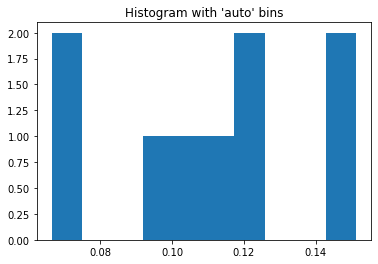

Train images


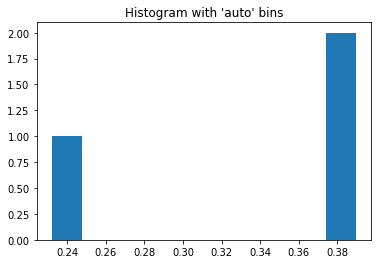

Train images


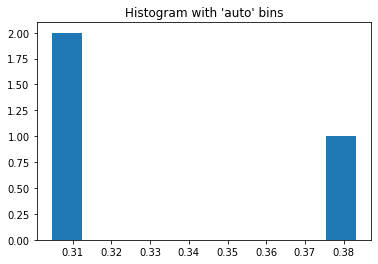

Train images


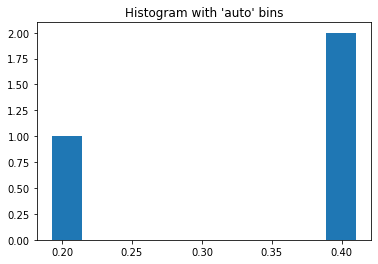

Train images


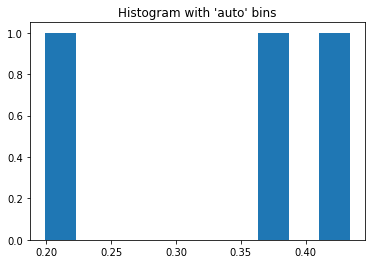

Train images


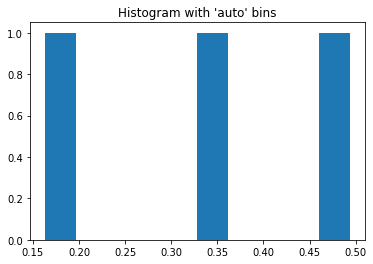

Train images


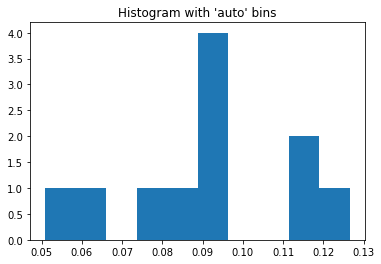

Train images


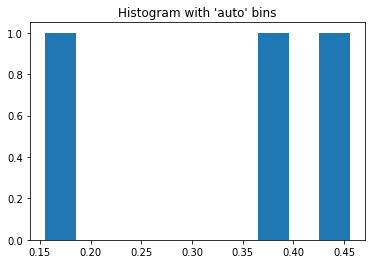

Train images


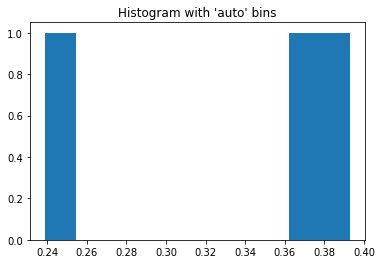

Train images


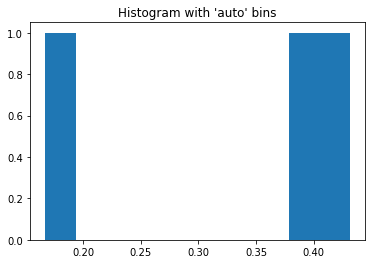

Train images


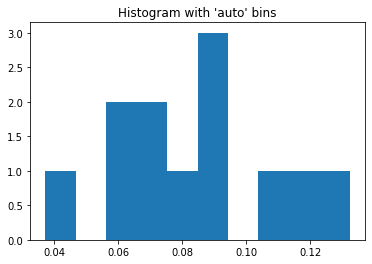

Train images


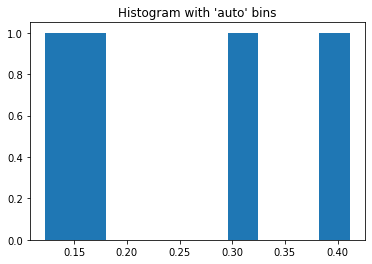

Train images


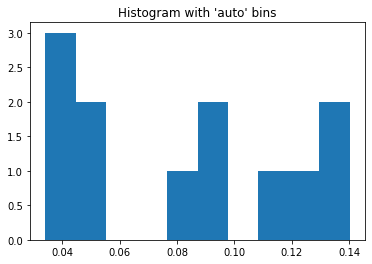

Train images


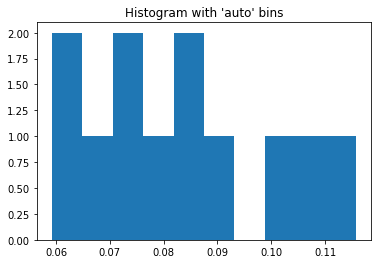

Train images


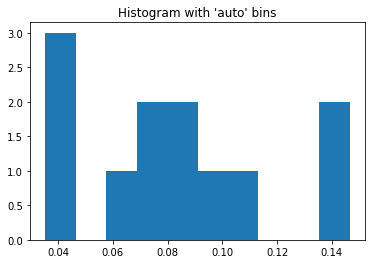

Train images


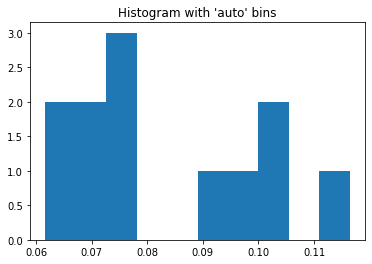

Train images


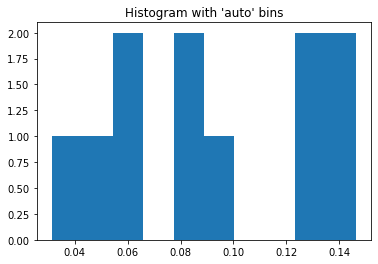

Train images


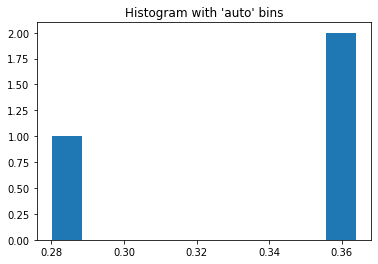

Train images


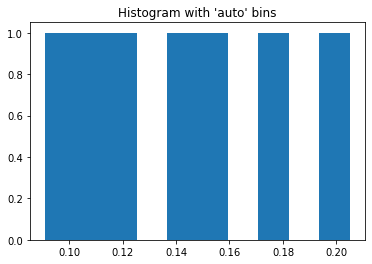

Train images


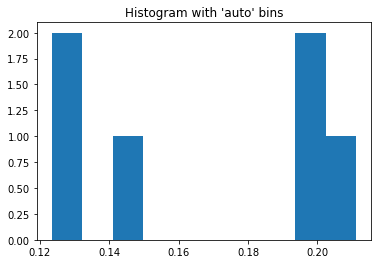

Train images


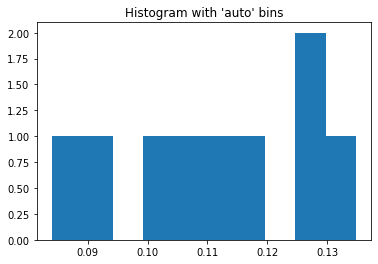

Train images


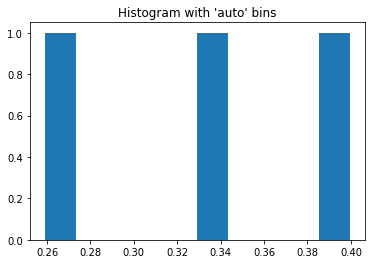

Train images


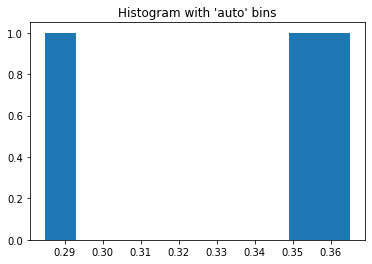

Train images


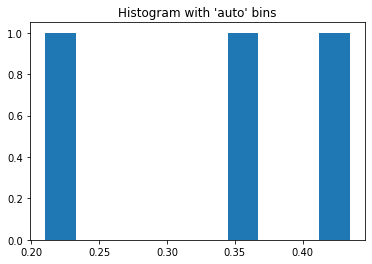

Train images


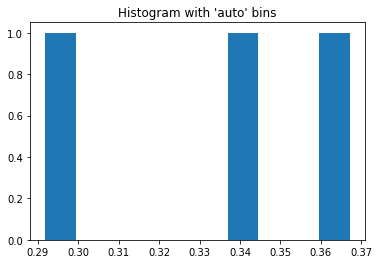

Train images


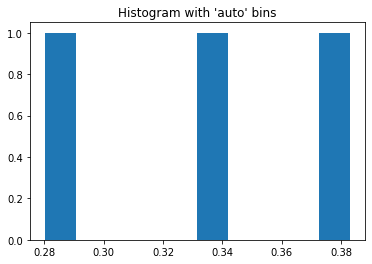

Train images


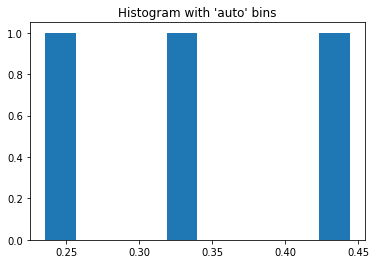

Train images


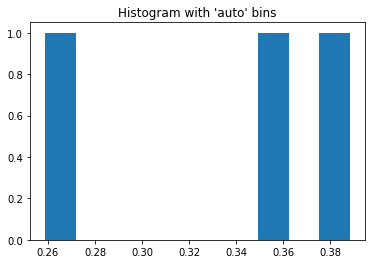

Train images


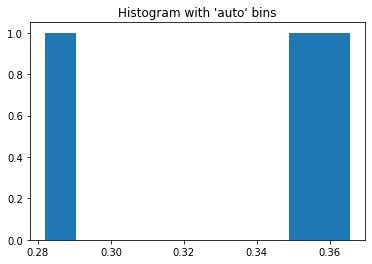

Train images


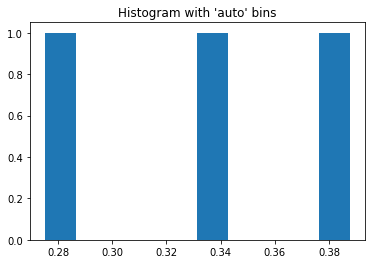

Train images


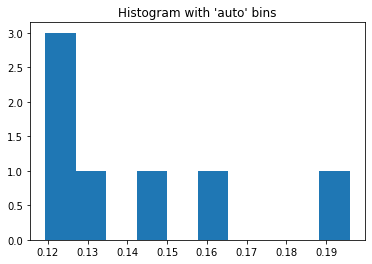

Train images


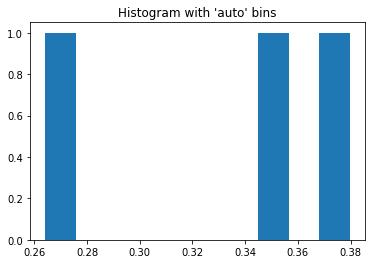

Train images


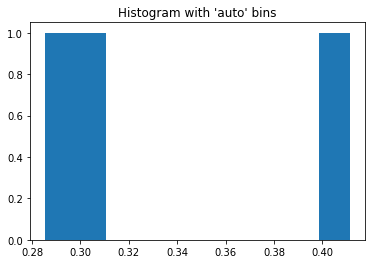

Train images


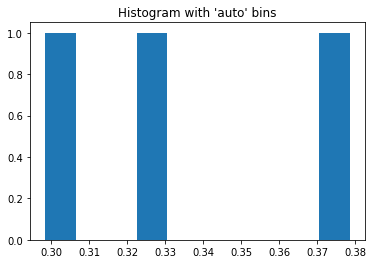

Train images


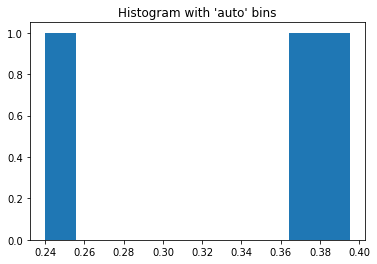

Train images


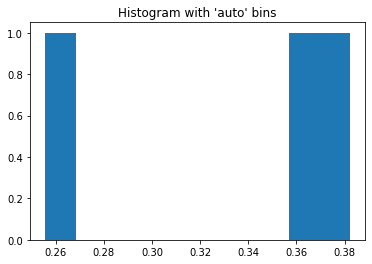

Train images


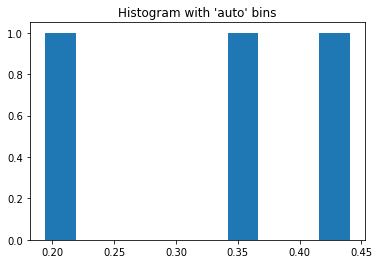

Train images


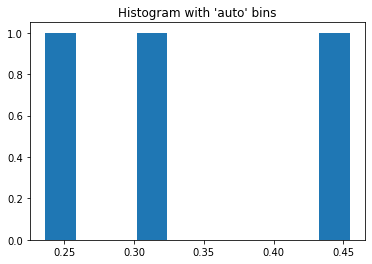

Train images


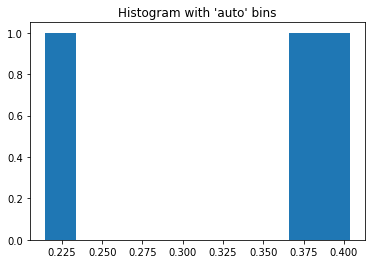

Train images


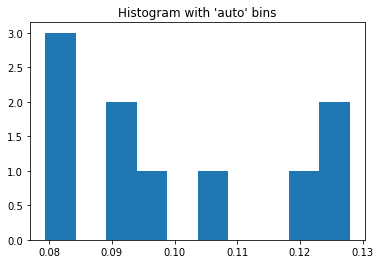

Train images


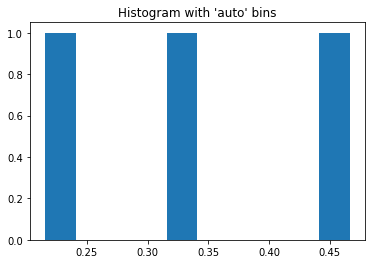

Train images


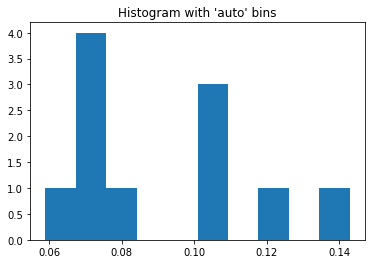

Train images


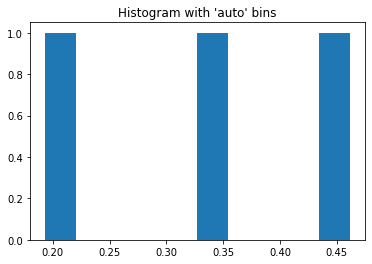

Train images


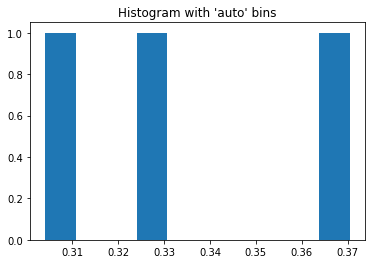

Train images


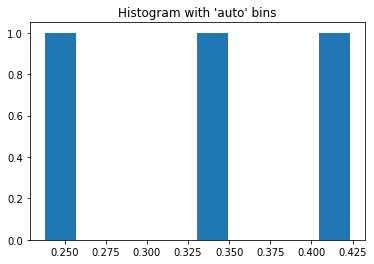

Train images


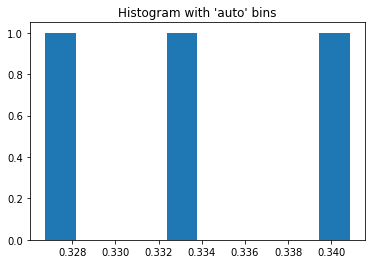

Train images


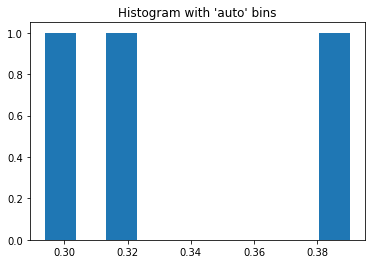

Train images


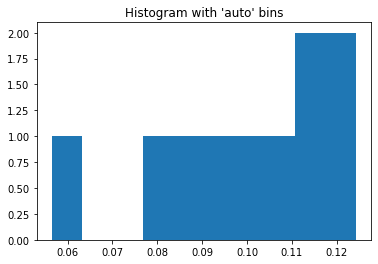

Train images


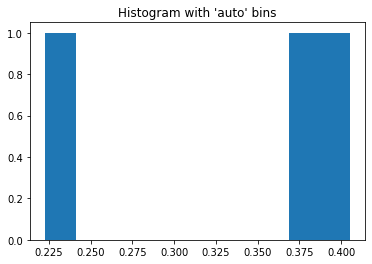

Train images


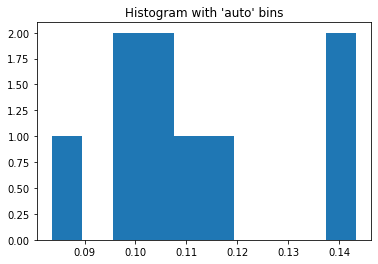

Train images


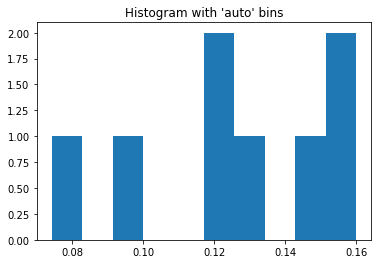

Train images


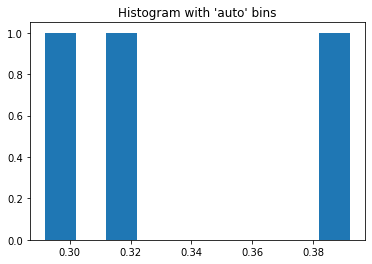

Train images


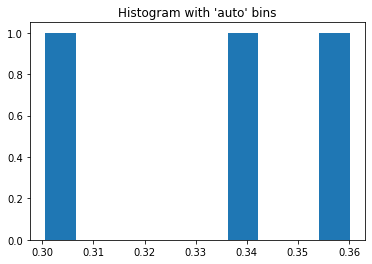

Train images


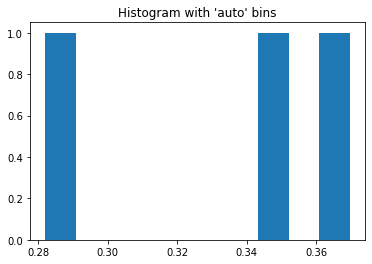

Train images


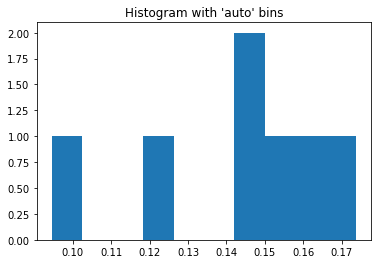

Train images


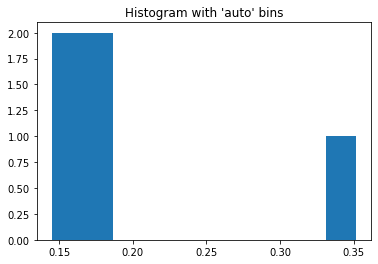

Train images


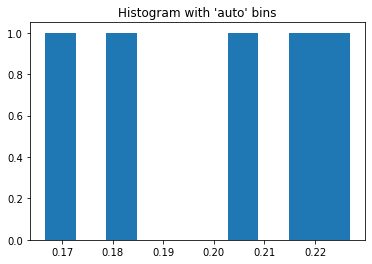

Train images


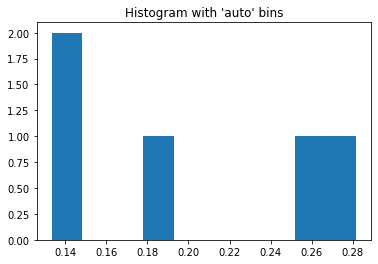

Train images


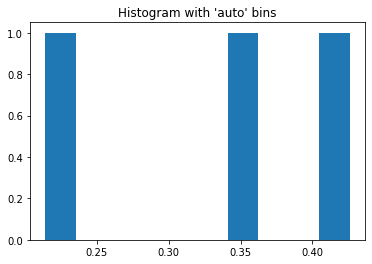

Train images


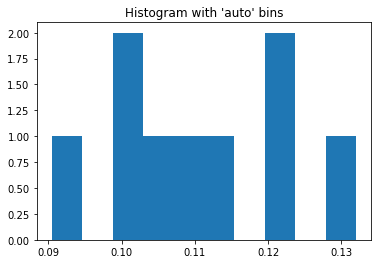

Train images


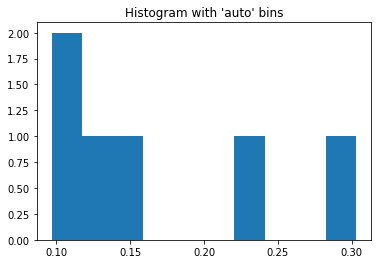

Train images


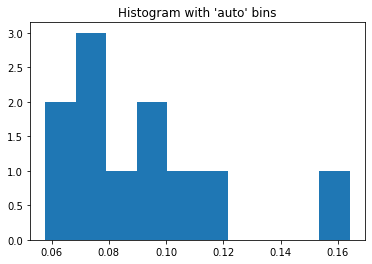

Train images


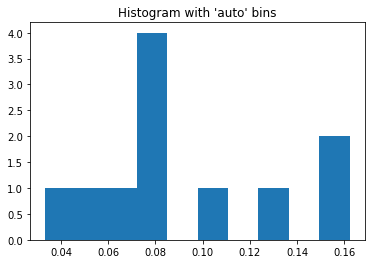

Train images


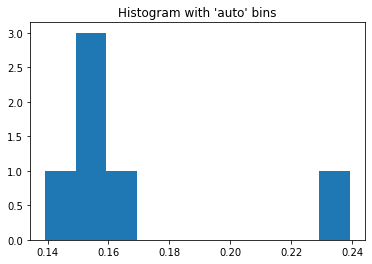

Train images


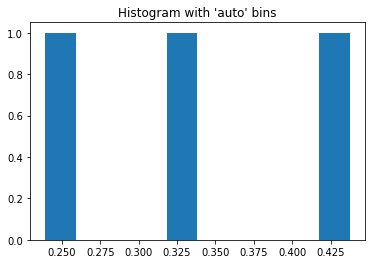

Train images


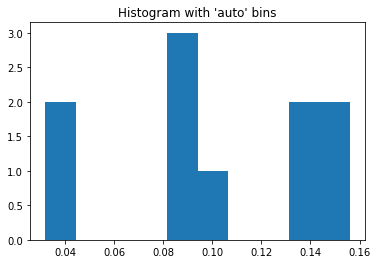

Train images


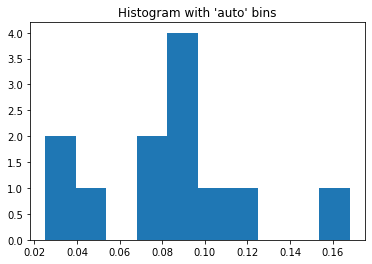

Train images


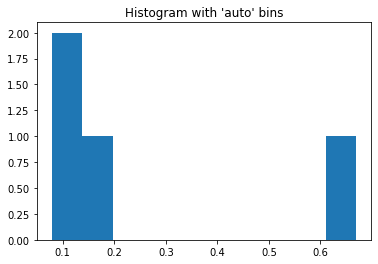

Train images


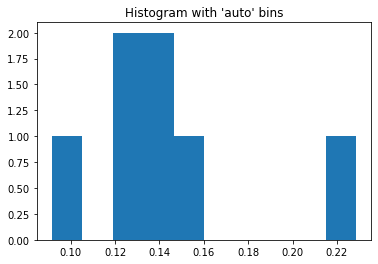

Train images


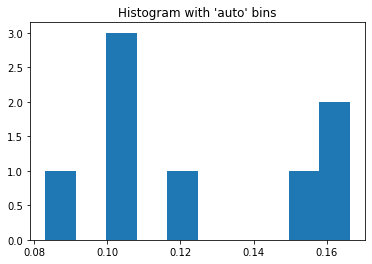

Train images


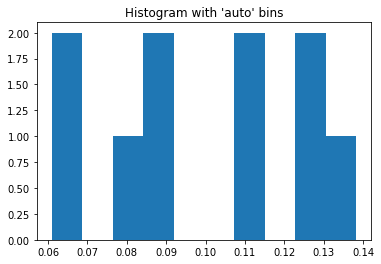

Train images


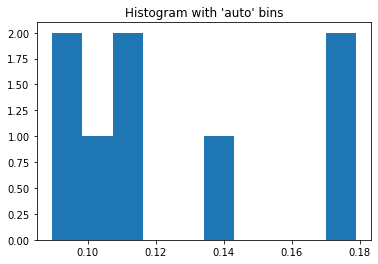

Train images


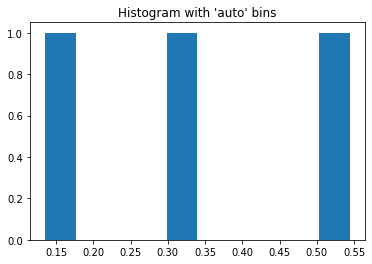

Train images


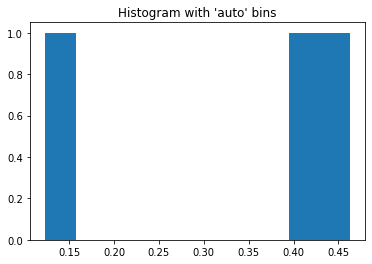

Train images


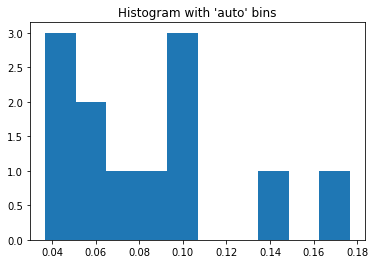

Train images


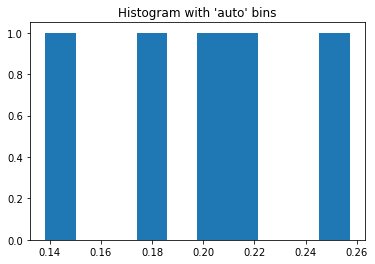

Train images


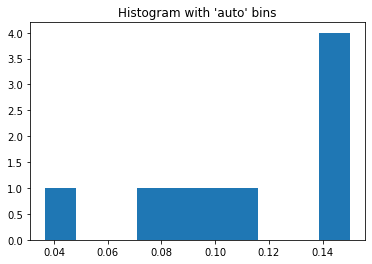

Train images


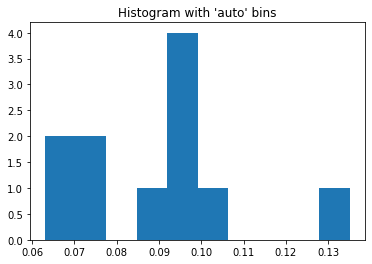

Train images


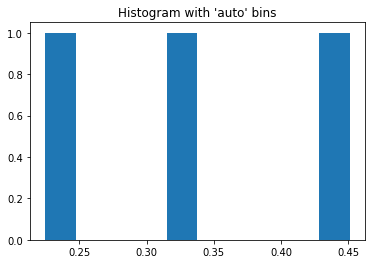

Train images


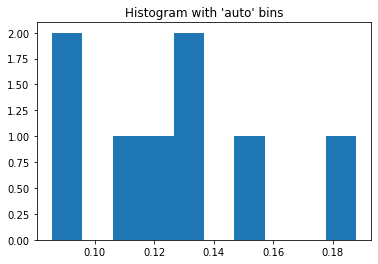

Train images


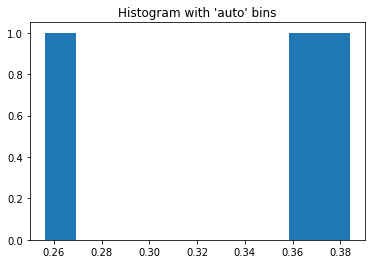

Train images


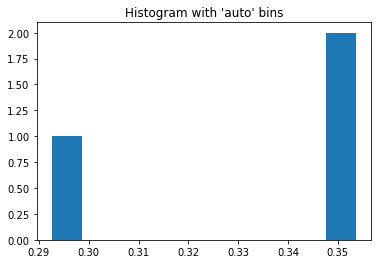

Train images


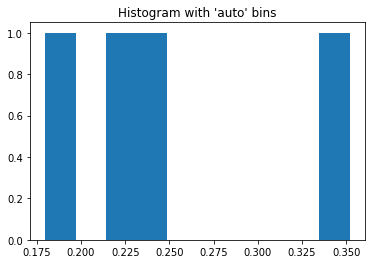

Train images


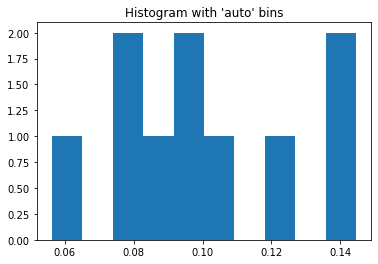

Train images


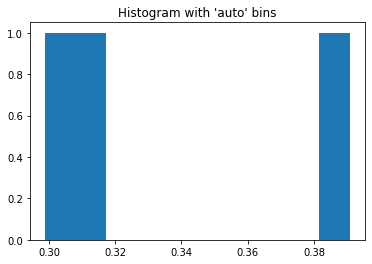

Train images


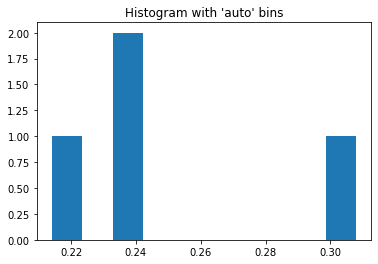

Train images


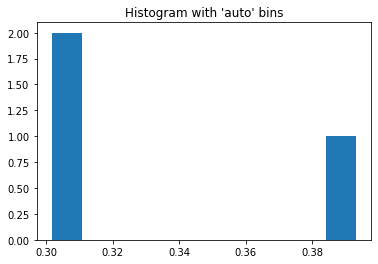

Train images


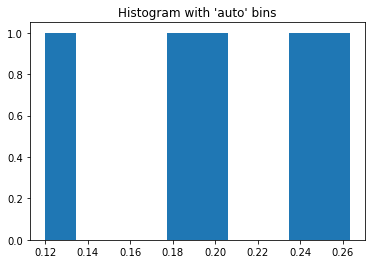

Train images


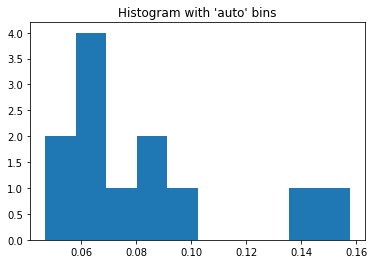

Train images


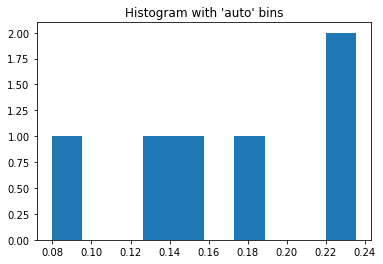

Train images


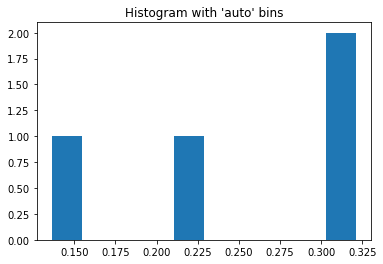

Train images


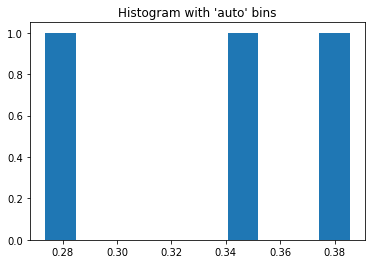

Train images


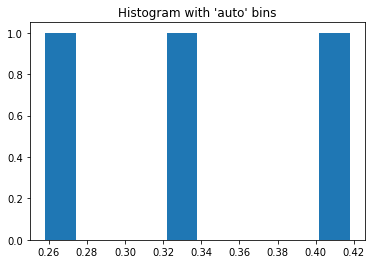

Train images


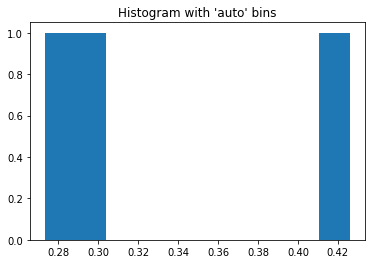

Train images


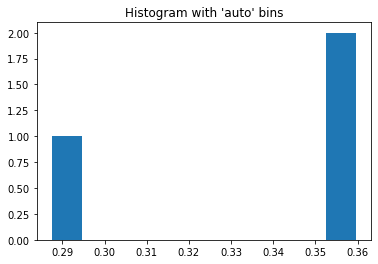

Train images


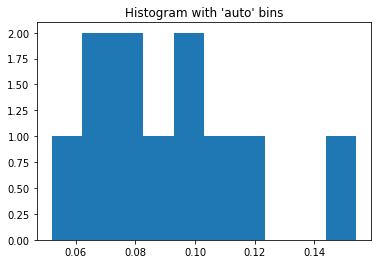

Train images


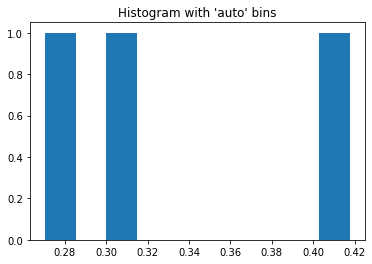

Train images


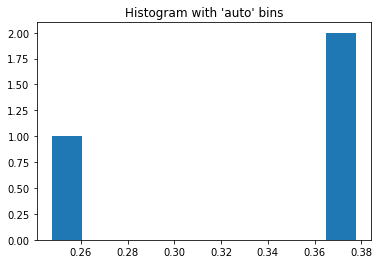

Train images


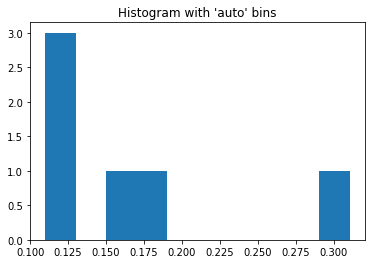

Train images


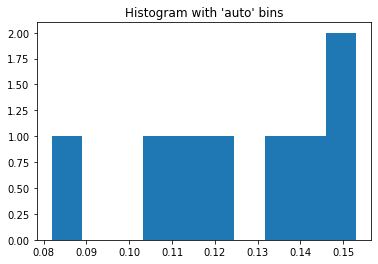

Train images


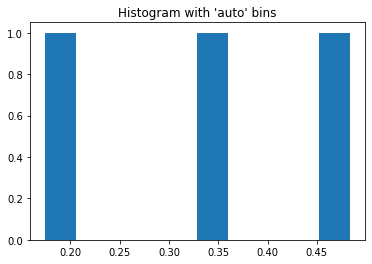

Train images


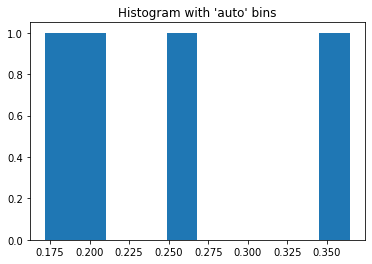

Train images


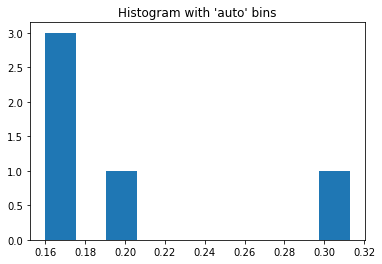

Train images


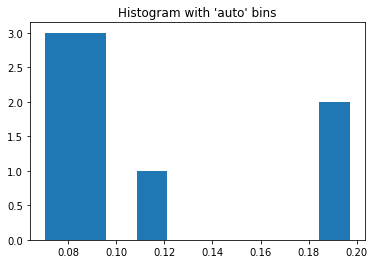

Train images


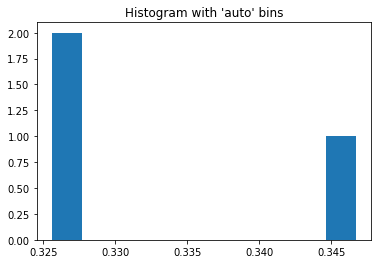

Train images


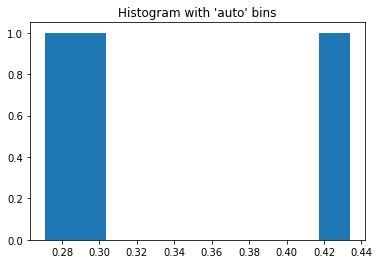

Train images


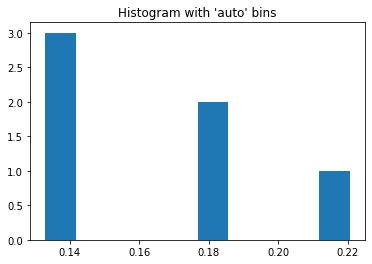

Train images


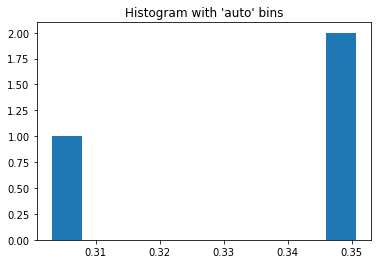

Train images


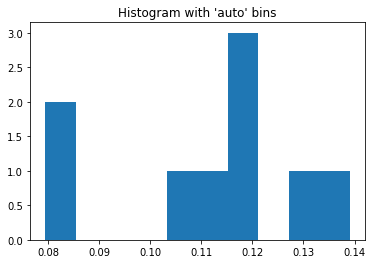

Train images


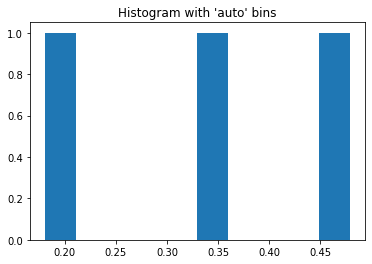

Train images


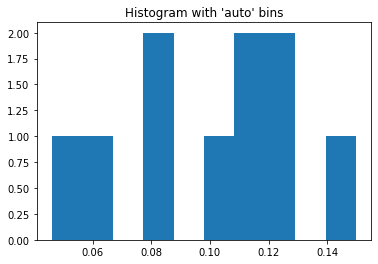

Train images


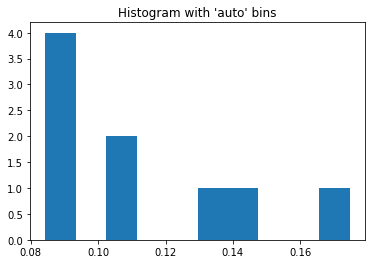

Train images


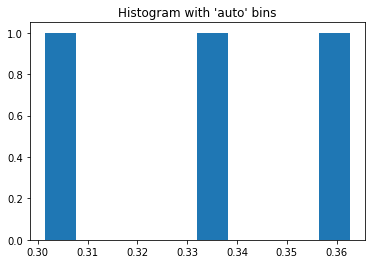

Train images


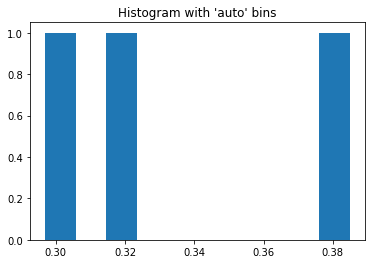

Train images


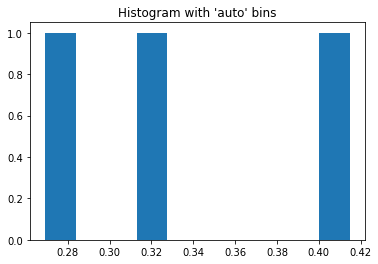

Train images


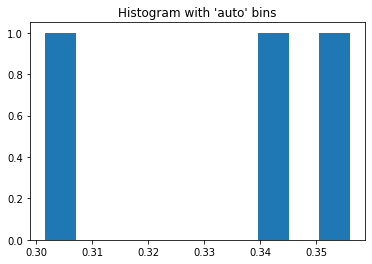

Train images


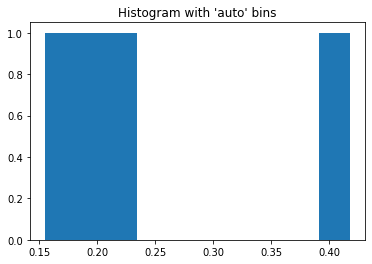

Train images


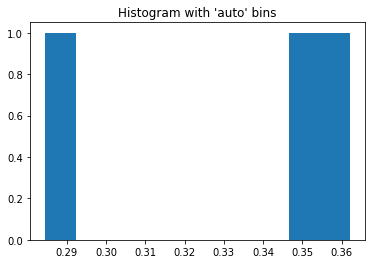

Train images


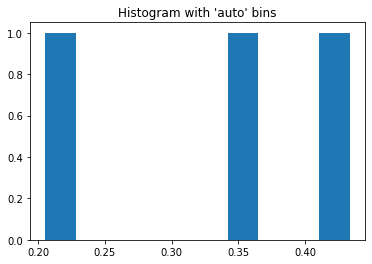

Train images


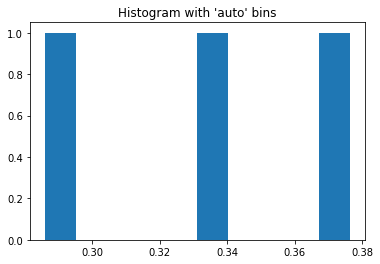

Train images


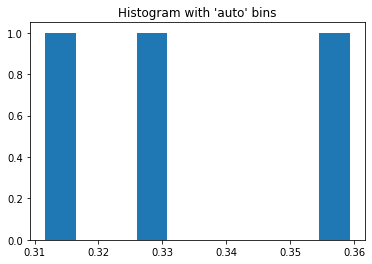

Train images


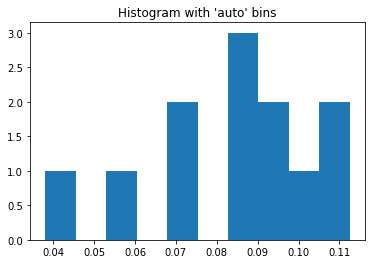

Train images


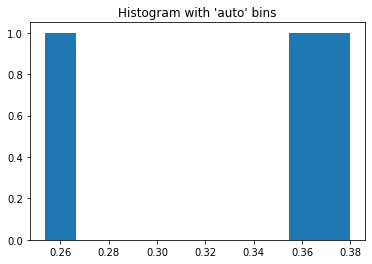

Train images


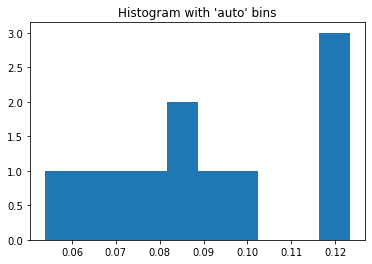

Train images


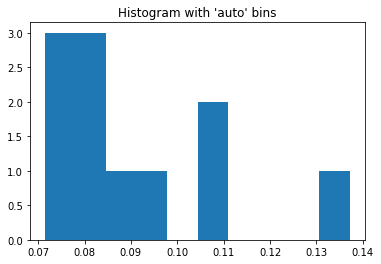

Train images


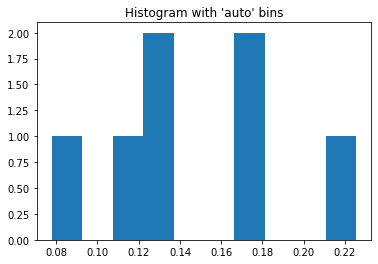

Train images


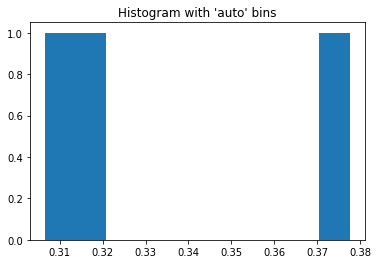

Train images


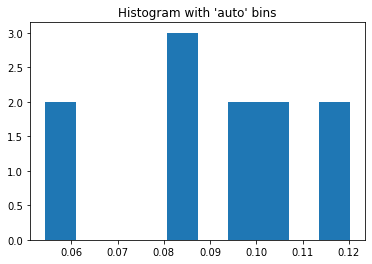

Train images


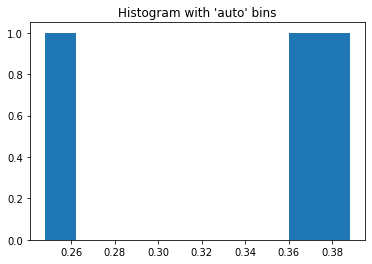

Train images


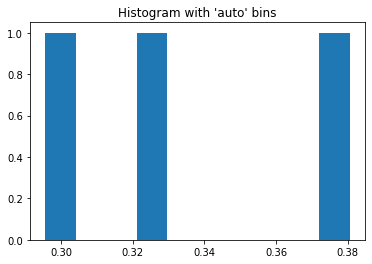

Train images


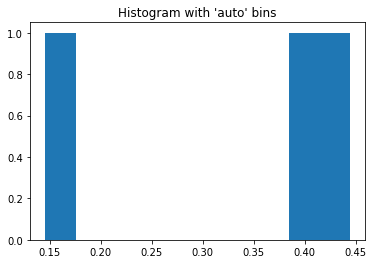

Train images


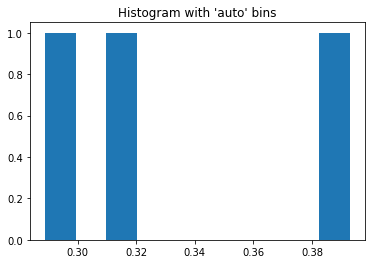

Train images


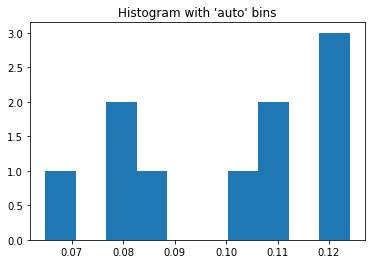

Train images


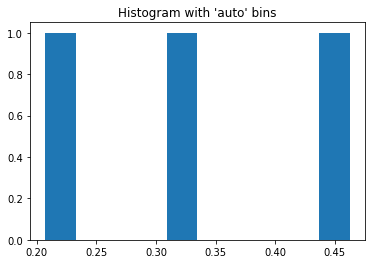

Train images


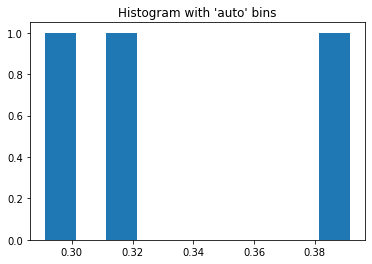

Train images


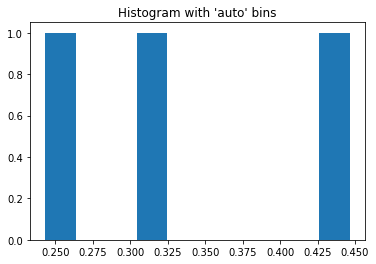

Train images


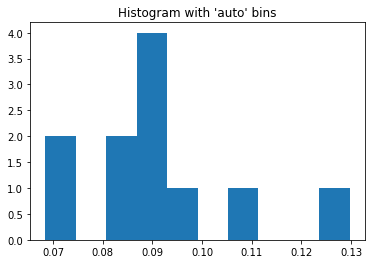

Train images


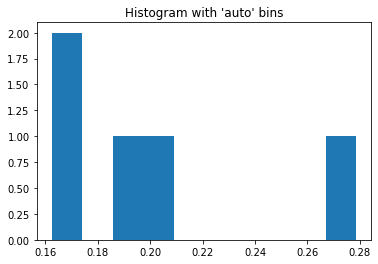

Train images


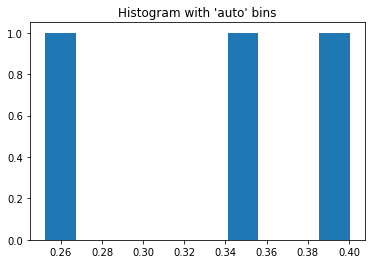

Train images


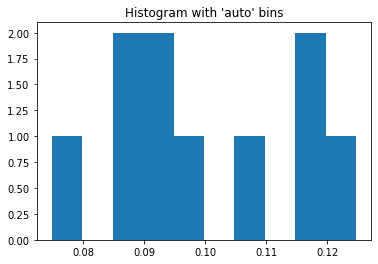

In [43]:

normalized_testing = []
for hist_test in test_preprocessed_images:
#Normalize the histogram
  print("Train images")
  #x = np.sum(hist_test)
  hist_norm_test = hist_test/np.sum(hist_test)
  normalized_testing.append(hist_norm_test)
  plt.hist(hist_norm_test)
  plt.title("Histogram with 'auto' bins")
  plt.show()

normalized_training = []
for hist_train in training_preprocessed_images:
#Normalize the histogram
  print("Train images")
  hist_norm_train = hist_train/np.sum(hist_train)
  normalized_training.append(hist_norm_train)
  plt.hist(hist_norm_train)
  plt.title("Histogram with 'auto' bins")
  plt.show()



## Step 4 - Classification (Nearest Neighbour) ##


In [62]:
data = []

# Add all the normalized histograms to a single array
for i in normalized_training:
  data.append(i)

for i in normalized_testing:
  data.append(i)

# Split images into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.37, random_state=42)


# Nearest Neighbour L2 distance function
def L2_NN(trainx, trainy, testx):
  testy_L2 = []
  for i in range(len(testx)):

    # Calculate the L2 distance

    for j in range(len(trainx)):
      for z in range(len(trainx[j])):
        distance = np.sum(np.square(testx[i]- trainx[j][z]))
        

    test_predicted = trainy[np.argmin(distance)]
    testy_L2.append(test_predicted)
  
  return np.asarray(testy_L2)


testy_L2 = L2_NN(X_train, y_train,X_test)

## Part 5 - Calculate the error rate ##



In [63]:
def error_rate(testy, testy_fit):
  return float(np.sum(testy!=testy_fit))/len(testy)

print("Error rate:", error_rate(y_test, testy_L2))

acc = (1 - error_rate(y_test, testy_L2)) * 100
print("Accuracy Rate: ", acc, "%")

Error rate: 0.75
Accuracy Rate:  25.0 %


## Part 5 - Confusion Matrix ##

In [65]:
def confusionMatrix(testy, testy_fit):
  matrix_dimension = len(np.unique(testy))
  print(matrix_dimension)
  confusionMatrix = np.zeros((matrix_dimension, matrix_dimension))
  for i in range(len(testy)):
    confusionMatrix[int(testy[i])][int(testy_fit[i])] +=1

  return confusionMatrix


confusionMatrix(y_test, testy_L2)

4


array([[ 0., 19.,  0.,  0.],
       [ 0., 13.,  0.,  0.],
       [ 0.,  9.,  0.,  0.],
       [ 0., 11.,  0.,  0.]])

## Part 6 - Histogram intersection between 2 histograms## 

In [61]:
def hist_inter(h1, h2):
  sm = 0
  b = 0
  if len(h1) > len(h2):
    b = len(h2)
  else:
    b = len(h1)
  for i in range(b):
    sm += min(h1[i], h2[i])
  return sm



def Intersection_NN(trainx, trainy, testx):
  testy_Intersection = []

  for i in range(len(testx)):


    hist_intersection = hist_inter(testx[i], trainx[i])
    print("Intersection", hist_intersection)


    test_predicted = trainy[np.argmin(hist_intersection)]

    testy_Intersection.append(test_predicted)

  return np.asarray(testy_Intersection)


testy_Intersection = Intersection_NN(X_train, y_train,X_test)


def error_rate(testy, testy_fit):
  return float(np.sum(testy!=testy_fit))/len(testy)

print("Error rate:", error_rate(y_test, testy_Intersection))

acc = (1 - error_rate(y_test, testy_Intersection)) * 100
print("Accuracy Rate: ", acc, "%")


def confusionMatrix(testy, testy_fit):
  matrix_dimension = len(np.unique(testy))
  confusionMatrix = np.zeros((matrix_dimension, matrix_dimension))
  for i in range(len(testy)):
    confusionMatrix[int(testy[i])][int(testy_fit[i])] +=1

  return confusionMatrix


confusionMatrix(y_test, testy_Intersection)


Intersection 0.2863961813842482
Intersection 0.8572146807440925
Intersection 0.46578947368421053
Intersection 0.6323561841196101
Intersection 0.7895429064251832
Intersection 0.3353658536585366
Intersection 0.8173613223810973
Intersection 0.8182462927143778
Intersection 0.34328358208955223
Intersection 0.9560617722679855
Intersection 0.2578947368421053
Intersection 0.3652482269503546
Intersection 0.5437262357414449
Intersection 0.5647921760391198
Intersection 0.33774834437086093
Intersection 0.9488373856636176
Intersection 0.8661127348643005
Intersection 0.568614838638128
Intersection 0.8995758894236052
Intersection 0.6388807572209212
Intersection 0.5423800139590261
Intersection 0.668956734901786
Intersection 0.2118780096308186
Intersection 0.5321428571428571
Intersection 0.3192090395480226
Intersection 0.8265330228476935
Intersection 0.3919308357348703
Intersection 0.8949689251876131
Intersection 0.5740740740740741
Intersection 0.7842803738317756
Intersection 0.34459459459459457
Inters

array([[ 0., 19.,  0.,  0.],
       [ 0., 13.,  0.,  0.],
       [ 0.,  9.,  0.,  0.],
       [ 0., 11.,  0.,  0.]])